In [3]:
from citylearn import  CityLearn
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

In [4]:
# Load environment
data_folder = Path("data/")
building_attributes = data_folder / 'building_attributes.json'
solar_profile = data_folder / 'solar_generation_1kW.csv'
building_state_actions = 'buildings_state_action_space.json'
building_ids = ["Building_1","Building_2","Building_3","Building_4","Building_5","Building_6","Building_7","Building_8","Building_9"]
env = CityLearn(building_attributes, solar_profile, building_ids, buildings_states_actions = building_state_actions, cost_function = ['ramping','1-load_factor','average_daily_peak','peak_demand','net_electricity_consumption','quadratic'])
observations_spaces,actions_spaces = env.get_state_action_spaces()

In [5]:
# Simulation without energy storage
env.reset()
done = False
while not done:
    _, rewards, done, _ = env.step([[0 for _ in range(len(actions_spaces[i].sample()))] for i in range(len(building_ids))])
cost_no_es = env.cost()

In [6]:
cost_no_es # costs from CityLearn with no Energy Storage negative peak to valley ratio

{'ramping': 0.6996840329353438,
 '1-load_factor': 1.1305543212285898,
 'average_daily_peak': 1.143303134361694,
 'peak_demand': 1.2756352995827362,
 'net_electricity_consumption': 1.0457594791474256,
 'quadratic': 1.193992883500169,
 'total': 1.0814881917926595}

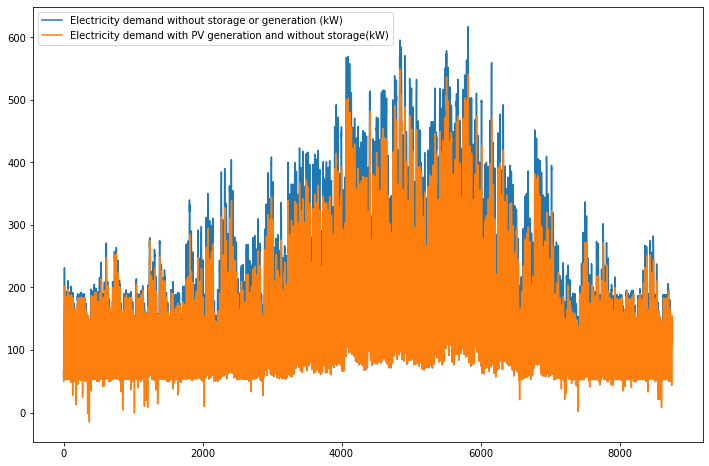

In [12]:
interval = range(0,8759)
plt.figure(figsize=(12,8))
plt.plot(env.net_electric_consumption[interval]+env.electric_generation[interval]-env.electric_consumption_cooling_storage[interval]-env.electric_consumption_dhw_storage[interval])
plt.plot(env.net_electric_consumption[interval]-env.electric_consumption_cooling_storage[interval]-env.electric_consumption_dhw_storage[interval])
plt.legend(['Electricity demand without storage or generation (kW)', 'Electricity demand with PV generation and without storage(kW)'])

In [8]:
#RULE-BASED CONTROLLER (RBC) (Stores energy at night and releases it during the day)
from agent import RBC_Agent

#Instantiatiing the control agent(s)
agents = RBC_Agent(actions_spaces)

state = env.reset()
done = False
while not done:
    action = agents.select_action(state)
    next_state, rewards, done, _ = env.step(action)
    state = next_state
cost_rbc = env.cost()

In [9]:
cost_rbc

{'ramping': 1.0,
 '1-load_factor': 1.0,
 'average_daily_peak': 1.0,
 'peak_demand': 1.0,
 'net_electricity_consumption': 1.0,
 'quadratic': 1.0,
 'total': 1.0}

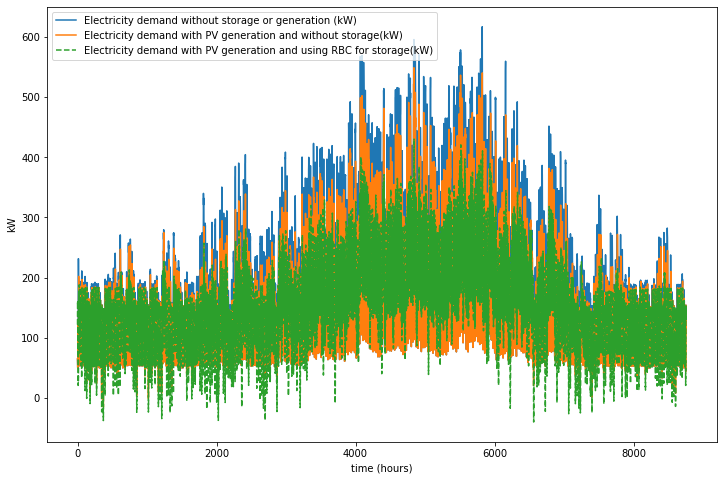

In [10]:
interval = range(0,8759)
plt.figure(figsize=(12,8))
plt.plot(env.net_electric_consumption[interval]+env.electric_generation[interval]-env.electric_consumption_cooling_storage[interval]-env.electric_consumption_dhw_storage[interval])
plt.plot(env.net_electric_consumption[interval]-env.electric_consumption_cooling_storage[interval]-env.electric_consumption_dhw_storage[interval])
plt.plot(env.net_electric_consumption[interval], '--')
plt.xlabel('time (hours)')
plt.ylabel('kW')
plt.legend(['Electricity demand without storage or generation (kW)', 'Electricity demand with PV generation and without storage(kW)', 'Electricity demand with PV generation and using RBC for storage(kW)'])

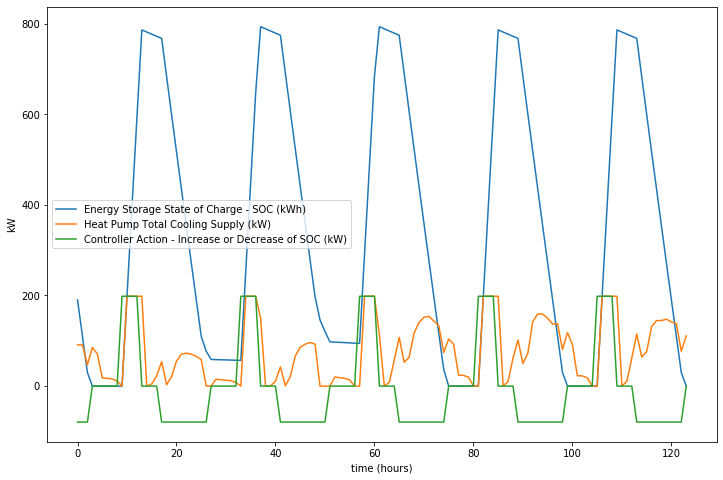

In [11]:
# Plot for one building of the total cooling supply, the state of charge, and the actions of the controller
plt.figure(figsize=(12,8))
building_number = 3 # from 0 to 8
plt.plot(env.buildings[building_number].cooling_storage.soc_list[4000:4124])
plt.plot(env.buildings[building_number].cooling_device.cooling_supply[4000:4124])
plt.plot([k[0][0]*env.buildings[building_number].cooling_storage.capacity for k in [j for j in agents.action_tracker[4000:4124]]])
plt.xlabel('time (hours)')
plt.ylabel('kW')
plt.legend(['Energy Storage State of Charge - SOC (kWh)', 'Heat Pump Total Cooling Supply (kW)', 'Controller Action - Increase or Decrease of SOC (kW)'])